### Stress strain diagram for grafted CTs, along with toughness comparison for architected structures. 

This code creates the figure comparing grafted CTs to AF360GD samples.

/var/folders/kj/qgdkbr2x2wv543ldljv50bvw0000gn/T/ipykernel_81554/4010006219.py:107: DeprecationWarning: You are passing x=0       0.000633
1       0.001051
2       0.001470
3       0.001885
4       0.002303
          ...   
1195    0.498554
1196    0.498971
1197    0.499387
1198    0.499805
1199    0.500083
Name: strain, Length: 1200, dtype: float64 as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  toughness = simpson(data['stress'], data['strain'])
/var/folders/kj/qgdkbr2x2wv543ldljv50bvw0000gn/T/ipykernel_81554/4010006219.py:107: DeprecationWarning: You are passing x=0       0.000402
1       0.000822
2       0.001237
3       0.001655
4       0.002071
          ...   
1196    0.498740
1197    0.499157
1198    0.499572
1199    0.499990
1200    0.500060
Name: strain, Length: 1201, dtype: float64 as a positional argument. Please change your invocation to use keyword arguments

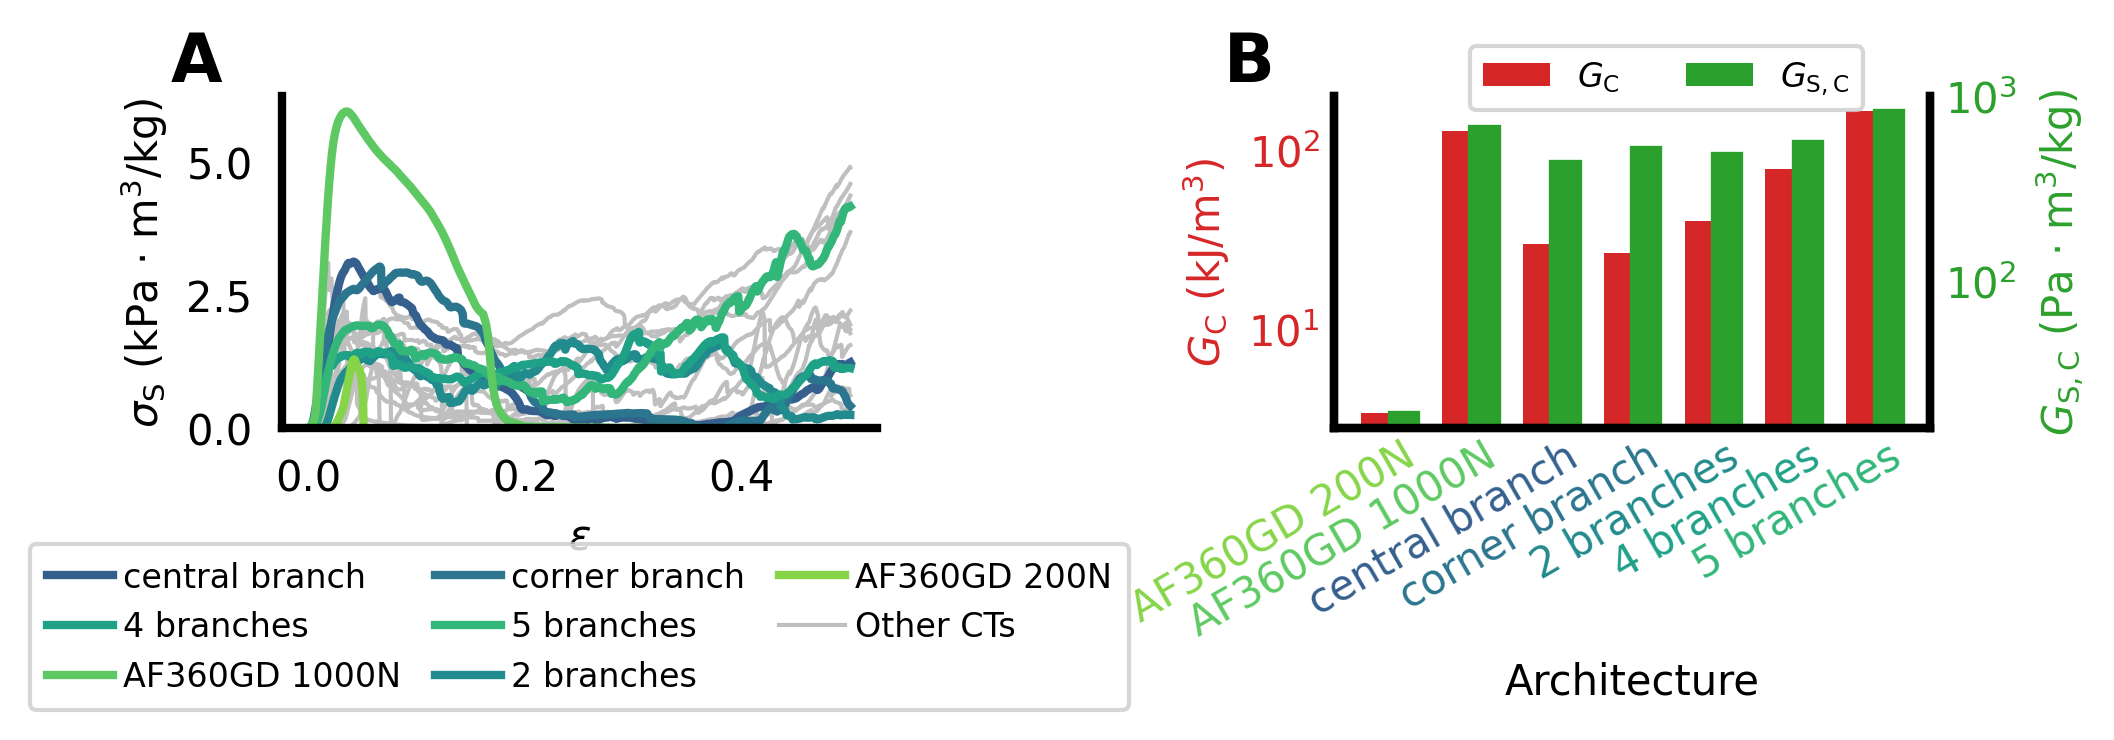

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mplb
import re
import numpy as np
from scipy.integrate import simpson
from scipy.signal import find_peaks
from matplotlib.cm import viridis
import matplotlib.lines as mlines


# Sample data
sample_data = {
    'Sample Name': [1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 16, 17, 18, 'central branch', 'corner branch',
                    '2 branches', '4 branches', '5 branches', 'AF360GD 1000N', 'AF360GD 200N'],
    'Run Number': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 21, 24, 20, 23, 19, 18],
    'CID': [1.351194521333335, 1.3244232303333345, 1.2798845243333343, 1.2000391123333334, 1.057836644333332, 1.3156118143333344, 
            1.3244232303333345, 1.368923781333335, 1.3156118143333344, 1.2267622463333336, 1.3423437923333348, 1.3423437923333348, 
            1.3156118143333344, 1.2798845243333343, 0.417788062333334, 0.44109578133333394, 0.5810975063333336, 0.8221899613333329, 
            0.9688164073333312, 'N/A', 'N/A'],
    'Voxel Count': [5660, 2441, 2395, 1510, 1031, 3128, 4389, 5500, 2569, 1785, 4769, 6050, 3637, 3454, 1488, 1108, 1791, 2983, 4305, 4059, 3809]
}

axesfontsize=10
legendfontsize=8
markersize=4
BIGfont=16

# Convert sample data to DataFrame
df_samples = pd.DataFrame(sample_data)

# Filter samples with names involving words
df_filtered = df_samples[df_samples['Sample Name'].apply(lambda x: isinstance(x, str))]

# Density of PLA in g/cm^3
density_pla = 1.25  # g/cm^3
# Convert density to kg/mm^3 for compatibility with voxel volume (1 mm^3)
density_pla_kg_per_mm3 = density_pla * 1e-3 * 1e-3 # g to kg and cm^-3 to mm^-3

# Net generation volume in m^3
net_generation_volume_m3 = 30e-3 * 30e-3 * 30e-3  # 30mm * 30mm * 30mm

# Set your main directory here
main_folder_path = 'Data/MTS_Runs/'

# Function to extract run number from folder name
def extract_run_number(folder_name):
    match = re.search(r'Test Run (\d+)', folder_name)
    if match:
        return int(match.group(1))
    else:
        return None

# List all subdirectories in the main directory
subfolders = [os.path.join(main_folder_path, f.name) for f in os.scandir(main_folder_path) if f.is_dir()]

# Filter and sort the subfolders based on the run number
filtered_subfolders = []
for folder in subfolders:
    run_number = extract_run_number(os.path.basename(folder))
    if run_number:
        filtered_subfolders.append((folder, run_number))

filtered_subfolders.sort(key=lambda x: x[1])

# Define colormap for different numbers of branches using viridis subsets
branch_colormap = {
    'central branch': viridis(0.3),          # Dark Blue-Green from viridis (cool)
    'corner branch': viridis(0.39),          # Blue-Green from viridis (cool)
    '2 branches': viridis(0.48),              # Greenish-Blue from viridis (cool)
    '4 branches': viridis(0.57),             # Light Green-Blue from viridis (cool)
    '5 branches': viridis(0.66),              # Green from viridis (cool)
    'AF360GD 1000N': viridis(0.75),           # Light Green from viridis (warm)
    'AF360GD 200N': viridis(0.82)            # Yellow-Green from viridis (warm)
}



branch_colormap_2 = {k: plt.cm.colors.to_hex(v) for k, v in branch_colormap.items()}

# Initialize a list to store the toughness for each run
toughness_and_peak_counts = []

# Function to find all relevant peaks
def find_all_relevant_peaks(data, prominence_factor=0.01, drop_threshold=0.05):
    prominence = data['stress'].max() * prominence_factor
    peaks, _ = find_peaks(data['stress'], prominence=prominence)
    relevant_peaks = []
    for peak in peaks:
        peak_stress = data.iloc[peak]['stress']
        for i in range(peak + 1, len(data)):
            if data.iloc[i]['stress'] <= peak_stress * (1 - drop_threshold):
                relevant_peaks.append((data.iloc[peak]['stress'], data.iloc[peak]['strain']))
                break
    return relevant_peaks

# Process each filtered and sorted folder
for folder, run_number in filtered_subfolders:
    file_path = os.path.join(folder, 'DAQ- Crosshead, … - (Timed).txt')
    if os.path.isfile(file_path):
        data = pd.read_csv(file_path, sep='\t', skiprows=7)
        data['strain'] = data['mm'] * (10**-3) / 36.0e-3
        data['stress'] = (data['kN'] * 1000) / (30e-3 * 30e-3)

        # Calculate toughness using Simpson's rule for numerical integration
        toughness = simpson(data['stress'], data['strain'])

        relevant_peaks_01_05 = find_all_relevant_peaks(data, prominence_factor=.01, drop_threshold=.05)
        num_fracture_peaks_01_05 = len(relevant_peaks_01_05)
        relevant_peaks_05_05 = find_all_relevant_peaks(data, prominence_factor=.05, drop_threshold=.05)
        num_fracture_peaks_05_05 = len(relevant_peaks_05_05)
        relevant_peaks_05_01 = find_all_relevant_peaks(data, prominence_factor=.05, drop_threshold=.01)
        num_fracture_peaks_05_01 = len(relevant_peaks_05_01)
        relevant_peaks_05_10 = find_all_relevant_peaks(data, prominence_factor=.05, drop_threshold=.10)
        num_fracture_peaks_05_10 = len(relevant_peaks_05_10)

        toughness_and_peak_counts.append((run_number, toughness, num_fracture_peaks_01_05, num_fracture_peaks_05_05, num_fracture_peaks_05_01, num_fracture_peaks_05_10))

# Compile toughness data into a DataFrame 
toughness_df = pd.DataFrame(toughness_and_peak_counts, columns=['Run Number', 'Toughness', 'num_fracture_peaks_01_05', 'num_fracture_peaks_05_05', 'num_fracture_peaks_05_01', 'num_fracture_peaks_05_10'])

# Merge the sample data with toughness data
merged_df = pd.merge(toughness_df, pd.DataFrame(sample_data), on='Run Number', how='inner')

# Filter for architected samples (those with string names)
architected_samples = merged_df[merged_df['Sample Name'].apply(lambda x: isinstance(x, str))]

# Calculate specific toughness
architected_samples = architected_samples.copy()
for index, row in architected_samples.iterrows():
    voxel_count = row['Voxel Count']
    mass_kg = voxel_count * density_pla_kg_per_mm3
    sample_density = mass_kg / net_generation_volume_m3
    specific_toughness = row['Toughness'] / sample_density
    architected_samples.at[index, 'Specific Toughness'] = specific_toughness

architected_samples['Toughness'] = architected_samples['Toughness']/(1000) #convert to kJ/m^3
# Order the samples as specified
order = ['AF360GD 200N', 'AF360GD 1000N', 'central branch', 'corner branch', '2 branches', '4 branches', '5 branches']
architected_samples = architected_samples.set_index('Sample Name').loc[order].reset_index()

# Define bar width and positions
bar_width = 0.35
r1 = np.arange(len(architected_samples))
r2 = [x + bar_width for x in r1]

# Plotting both figures side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.01, 3.4), dpi=300)
# Plot all runs in gray first
for folder, run_number in filtered_subfolders:
    if run_number in df_samples['Run Number'].values:
        file_path = os.path.join(folder, 'DAQ- Crosshead, … - (Timed).txt')
        
        if os.path.isfile(file_path):
            # Read the data
            data = pd.read_csv(file_path, sep='\t', skiprows=7)
            
            # Calculate strain and stress
            data['strain'] = data['mm'] * (10**-3) / 36.0e-3
            data['stress'] = (data['kN'] * 1000) / (30e-3 * 30e-3)
            
            # Calculate the mass of the sample
            voxel_count = df_samples[df_samples['Run Number'] == run_number]['Voxel Count'].values[0]
            mass_kg = voxel_count * density_pla_kg_per_mm3
            
            # Calculate the density of the sample
            sample_density = mass_kg / net_generation_volume_m3
            
            # Calculate specific compressive stress
            data['specific_compressive_stress'] = data['stress'] / sample_density
            
            # Plot specific compressive stress-strain curve in gray
            ax1.plot(data['strain'], data['specific_compressive_stress'], color=(0.75, 0.75, 0.75), lw=1, zorder=1)

# Now plot selected runs from `plot_order` on top
plot_order=['central branch',
 'corner branch',
 '2 branches',
 '4 branches',
 '5 branches',
 'AF360GD 200N',
 'AF360GD 1000N']
for sample_name in plot_order:
    for folder, run_number in filtered_subfolders:
        if run_number in df_samples['Run Number'].values:
            current_sample_name = df_samples[df_samples['Run Number'] == run_number]['Sample Name'].values[0]
            if current_sample_name == sample_name:
                file_path = os.path.join(folder, 'DAQ- Crosshead, … - (Timed).txt')
                
                if os.path.isfile(file_path):
                    # Read the data
                    data = pd.read_csv(file_path, sep='\t', skiprows=7)
                    
                    # Calculate strain and stress
                    data['strain'] = data['mm'] * (10**-3) / 36.0e-3
                    data['stress'] = (data['kN'] * 1000) / (30e-3 * 30e-3)
                    
                    # Calculate the mass of the sample
                    voxel_count = df_samples[df_samples['Run Number'] == run_number]['Voxel Count'].values[0]
                    mass_kg = voxel_count * density_pla_kg_per_mm3
                    
                    # Calculate the density of the sample
                    sample_density = mass_kg / net_generation_volume_m3
                    
                    # Calculate specific compressive stress
                    data['specific_compressive_stress'] = data['stress'] / sample_density
                    
                    # Plot specific compressive stress-strain curve with color
                    color = branch_colormap.get(current_sample_name)
                    ax1.plot(data['strain'], data['specific_compressive_stress'], label=current_sample_name, color=color, lw=2, zorder=2)


import matplotlib.ticker as ticker

# Define a custom formatter function that divides the tick value by 1000
def thousandth_formatter(x, pos):
    return f'{x / 1000:.1f}'  # Adjust the formatting as needed (e.g., .1f for one decimal place)

# Apply the formatter to the y-axis of ax1
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(thousandth_formatter))

# Create a proxy artist to represent all gray lines in the legend
gray_line_legend = mlines.Line2D([], [], color=(0.75, 0.75, 0.75), linestyle='-', lw=1,label='Other CTs')

# Retrieve current legend handles and labels
handles, labels = ax1.get_legend_handles_labels()

# Define the desired order of legend items
order = ['central branch', 'corner branch', '2 branches', '4 branches', '5 branches', 'AF360GD 200N', 'AF360GD 1000N']

# Reorder handles and labels based on the desired order
ordered_handles = [handles[labels.index(o)] for o in order if o in labels]
ordered_labels = [o for o in order if o in labels]

# Append the proxy for "Other CTs"
ordered_handles.append(gray_line_legend)
ordered_labels.append('Other CTs')

# Define the order for left-to-right, then top-to-bottom layout
ordered_handles_left_to_right = [ordered_handles[i] for i in [0, 3, 6, 1, 4, 2, 5, 7]]
ordered_labels_left_to_right = [ordered_labels[i] for i in [0, 3, 6, 1, 4, 2, 5, 7]]

# Set up the legend with the combined handles and desired order
ax1.legend(
    ordered_handles_left_to_right,
    ordered_labels_left_to_right,
    loc='upper center',
    ncol=3,  # Number of columns
    bbox_to_anchor=(0.5, -0.35),  # Adjust as needed
    borderaxespad=0,
    borderpad=0.5,
    labelspacing=0.5,
    columnspacing=1,
    handletextpad=0.3,
    fontsize=legendfontsize
)


# ax1.set_title('Specific Compressive Stress vs. Strain for Selected Samples')
ax1.set_xlabel('$\\epsilon$', fontsize = axesfontsize)
ax1.set_ylabel('$\\sigma_{\\mathrm{S}}$ (kPa $\cdot$ m$^3$/kg)', fontsize = axesfontsize)
ax1.grid(False)

# Make the chart borders black
for spine in ax1.spines.values():
    spine.set_edgecolor('black')
# Plot combined bar chart with dual y-axes (Figure B)
color = 'tab:red'
ax2.set_xlabel('Architecture', fontsize = axesfontsize)
ax2.set_ylabel('$G_{\\mathrm{C}}$ (kJ/$\\mathrm{m^{3}}$)', color=color, fontsize = axesfontsize)
bars1 = ax2.bar(r1, architected_samples['Toughness'], color=color, width=bar_width, label='Toughness')
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(False)

# Create a second y-axis
ax3 = ax2.twinx()

# Plot specific toughness
color = 'tab:green'
ax3.set_ylabel('$G_{\\mathrm{S,C}}$(Pa $\cdot$ m$^3$/kg)', color=color)
bars2 = ax3.bar(r2, architected_samples['Specific Toughness'], color=color, width=bar_width, label='Specific Toughness')
ax3.tick_params(axis='y', labelcolor=color)
ax3.grid(False)

# Set the position of the x ticks and labels
ax2.set_xticks([r + bar_width / 2 for r in range(len(architected_samples))])
ax2.set_xticklabels(architected_samples['Sample Name'], rotation=30, ha='right', fontsize = axesfontsize)

# # Adjust the position of the x ticks slightly to the right
# x_tick_positions = [pos + 0.00001 for pos in ax2.get_xticks()]  # Shift all positions by 0.05
# ax2.set_xticks(x_tick_positions)

# Set the spine width to 2 for all spines in ax1
for spine in ax1.spines.values():
    spine.set_linewidth(2)

# Set the spine width to 2 for all spines in ax2
for spine in ax2.spines.values():
    spine.set_linewidth(2)

# Similarly, you can set the spine width for ax3, ax4, etc., if needed


# Apply colors to x-axis labels
for label in ax2.get_xticklabels():
    sample_name = label.get_text()
    if sample_name in branch_colormap:
        label.set_color(branch_colormap[sample_name])

# Make the chart borders black
for spine in ax2.spines.values():
    spine.set_edgecolor('black')
for spine in ax3.spines.values():
    spine.set_edgecolor('black')

# Add legends to B's axis
bars = [bars1, bars2]
labels = ['$G_{\\mathrm{C}}$', '$G_{\\mathrm{S,C}}$']
fig.legend(bars, labels, loc='upper left', bbox_to_anchor=(0.20, 1.2), bbox_transform=ax2.transAxes, fontsize=legendfontsize, ncol =2)

# Add labels A and B
ax1.text(-0.1, 1.20, 'A', transform=ax1.transAxes, fontsize=BIGfont, fontweight='bold', va='top', ha='right')
ax2.text(-0.1, 1.20, 'B', transform=ax2.transAxes, fontsize=BIGfont, fontweight='bold', va='top', ha='right')

# ax2.set_title('Toughness and Specific Toughness vs. Architecture for Architected Samples')

# Make the chart borders black, but remove the top and right spines from ax1
for spine in ['top', 'right']:
    ax1.spines[spine].set_visible(False)
for spine in ['bottom', 'left']:
    ax1.spines[spine].set_edgecolor('black')

# Make the chart borders black for ax2 and ax3, but remove the top spine
for spine in ['top']:
    ax2.spines[spine].set_visible(False)
    ax3.spines[spine].set_visible(False)

for spine in ['bottom', 'left', 'right']:
    ax2.spines[spine].set_edgecolor('black')
    ax3.spines[spine].set_edgecolor('black')

# Remove ticks from the right y-axis in ax2 but keep tick labels
ax2.tick_params(axis='y', which='both', length=0, right=False)

# If you want to keep the top x-axis labels but remove the ticks
ax2.tick_params(axis='x', which='both', length=0, top=False)

# If you also want to apply this to the twin axis (ax3), do the following:
ax3.tick_params(axis='y', which='both', length=0, right=False)
ax3.tick_params(axis='x', which='both', length=0, top=False)


# Set the y-axis limits for ax1 so that y=0 is at the bottom
ax1.set_ylim(bottom=0)

# Create offset transform by 5 points in x direction
dx = 8/72.; dy = 2/72. 
offset = mplb.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

for label in ax2.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)

ax3.spines['bottom'].set_zorder(3)  # Example of setting the spine's z-order higher
bars2 = ax3.bar(r2, architected_samples['Specific Toughness'], color='tab:green', edgecolor='tab:green', zorder=2, width=bar_width, label='Specific Toughness')
# Create a second y-axis
color = 'tab:green'
bars2 = ax3.bar(r2, architected_samples['Specific Toughness'], color=color, edgecolor=color, zorder=2, width=bar_width, label='Specific Toughness')
ax3.set_ylabel('$G_{\\mathrm{S,C}}$ (Pa $\cdot$ m$^3$/kg)', color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.grid(False)

# Draw the spines last to ensure they are on top of everything
for spine in ax3.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)
    spine.set_zorder(4)  # Ensure spines are drawn on top

# Draw the spines last to ensure they are on top of everything
for spine in ax1.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)
    spine.set_zorder(10)  # Ensure spines are drawn on top

for spine in ax2.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)
    spine.set_zorder(10)  # Ensure spines are drawn on top

for spine in ax3.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)
    spine.set_zorder(10)  # Ensure spines are drawn on top

    # Set the y-axis of ax2 to a logarithmic scale
ax2.set_yscale('log')

# If you also want to adjust the y-axis for the secondary axis (ax3), you can do the same:
ax3.set_yscale('log')

fig.subplots_adjust(wspace=0.4)  # Increase horizontal space between subplots

ax1.tick_params(left=False,bottom=False)  # Removes tick marks on the y-axis of the left plot


fig.tight_layout()  # Ensure everything fits without overlap
plt.show()
